# Tutorial 8a: Extracting data from images

*This tutorial was generated from a Jupyer notebook.  You can download the notebook [here](t8a_extracting_data_from_images.ipynb).*

In [1]:
import glob
import os
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd

# BE/Bi 103 utilities
import bebi103

# Image processing tools
import skimage
import skimage.io

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Before we can start working with images, we need to know how to do all of the more mundane things with them, like organizing, loading, storing, etc.  Images that wou want to analyze come is all sorts of formats and are organized in many different ways.  One instrument may give you a TIFF stack consisting of 8-bit images.  Another may give you a directory with lots of images in it with different names.  And so many instruments give you data in some proprietary format.  You need to know how to deal with lots of file formats and organization.

In this course, we will analyze many microscope images.  I very strongly advocate that all of your microscopy data be converted to the [OME-TIFF format](https://www.openmicroscopy.org/site/support/ome-model/ome-tiff/).  The metadata is easy to parse (it is all XML) and it is an attempt to have a standard image format.  You can convert lots of proprietary and open formats to OME-TIFF using the very handy tool [Bio-Formats](http://www.openmicroscopy.org/site/products/bio-formats).

We will on occasion use OME-TIFF format, but we will generally have a variety of formats of data we will analyze.  I generally will give them to you in exactly the format I received them in.

In today's tutorial, we will use a data set from some students in the class to practice loading images, defining ROIs, etc.

In this tutorial and throughout the class, we will use `scikit-image` to do almost all of our image processing.  It has continual development, with new features constantly being added.  For the fairly simple image processing we'll do in this course, it suffices for most of what we need.  The [course website](http://bebi103.caltech.edu/2014/links.html) has links to many other image processing toolkits, some Python-based and many not.  In particular, [OpenCV](http://opencv.org) is very powerful and has complete Python bindings.  OpenCV 3.0 is due out around New Years Day with expanded functionality and optimized speed performance.

## The data set

The data set comes from three Caltech graduate students, Mike Abrams, Claire Bedbrook, and Ravi Nath (the latter two are enrolled in this class) who are working on studying day and night behavior in jellyfish.  The photograph jellyfish over time and study their pulsing behavior.  A typical image is shown below.

<img src="images/nath_img.jpg">

A single jellyfish lives in each bin, or "condo."  The condos are 4 by 4 inches.  Over time, the jellyfish pulse.  Our task today is to get traces so we can measure pulse frequency.

We have two different data sets, day and night, each contained in their own directory.  The files are stored as `Frame_1.JPG`, `Frame_2.JPG`, and so on.  This can present a problem because if we sort them alphabetically, they will be out of order.  We can see this below.

In [2]:
# The directory containing daytime data
data_dir = '../data/abrams_et_al/Cassiopea_Pulsation/day'

# Glob string for images
im_glob = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob)

# Let's look at the first 10 entries
im_list[:10]

['../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545000.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545001.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545002.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545003.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545004.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545005.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545006.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545007.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545008.TIF',
 '../data/abrams_et_al/Cassiopea_Pulsation/day/Frame_545009.TIF']

## Loading and displaying images
The workhorse for much of our image processing is `scikit-image`.  We will load our first image using `scikit-image`.  When importing `scikit-image`, it is called `skimage`, and we need to import the submodules individually.  The submodule for reading and writing images is `skimage.io`.  We can use it to load and display an image.  Let's start with the first jellyfish image.

In [3]:
# Read in the image using skimage
im = skimage.io.imread(im_list[0])

# Let's get information about the image
print(type(im), im.dtype, im.shape)

<class 'numpy.ndarray'> uint16 (3, 480, 640)


So, the image is stored as a NumPy array of 16-bit `int`s.  The array is 3$\times$480$\times$640, which means this is an RGB image.  The first index of the image indicates the channel (red, green, or blue).  Cameras often store black and white images as RGB, so let's see if all three channels are the same.

In [4]:
# Test to see if each R, G, and B value is the same
((im[0,:,:] == im[1,:,:]) &  (im[1,:,:] == im[2:,:])).all()

True

Indeed they are, so we can just consider one of the channels in our analysis.

In [5]:
# Just slice the red channel
im = im[0,:,:]

Now, let's use `skimage.io.imshow()` to take a look at the image.

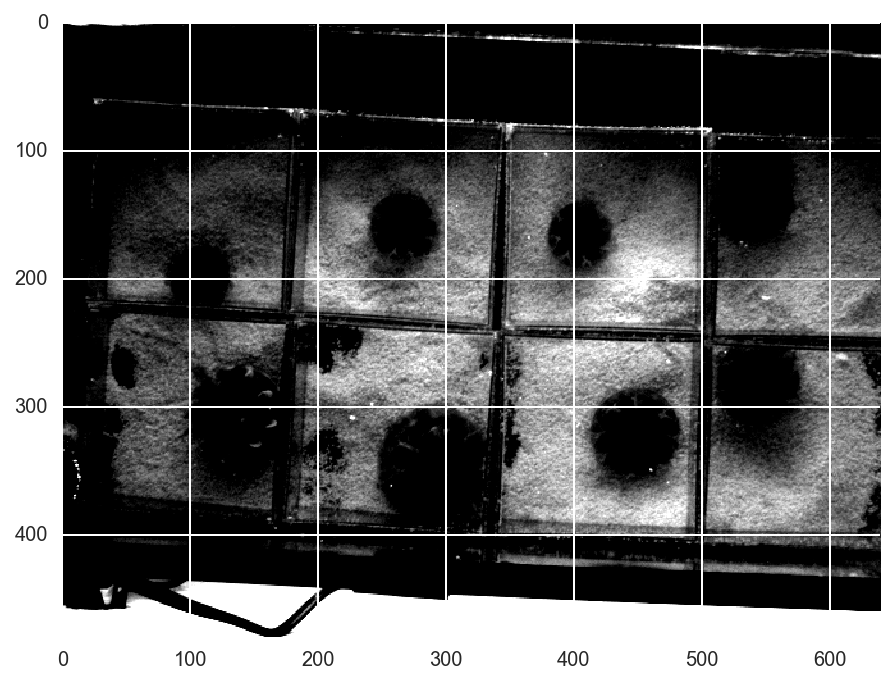

In [6]:
skimage.io.imshow(im)

To avoid the white gridlines (which we may or may not want), we can temporarily change Seaborn's axis style in a `with` block.

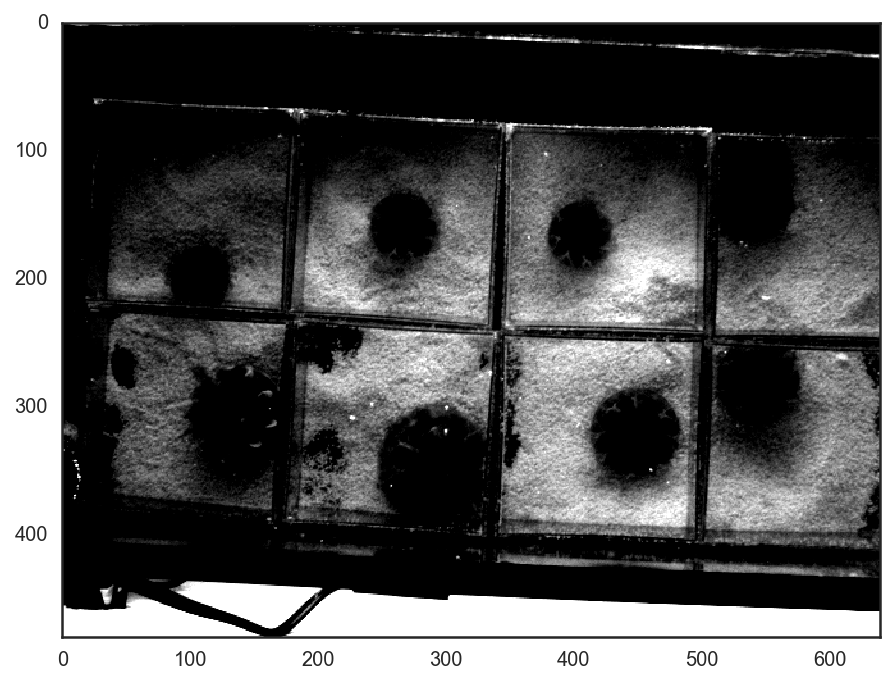

In [7]:
with sns.axes_style('white'):
    skimage.io.imshow(im)

## Burning a scale bar

Remember, scientific images are not just pretty pictures. It is crucially important that you know the interpixel distance and that the images have a scale bar when displayed, at least for publication.

For some microscope set-ups, we already know the physical length corresponding to the interpixel distance.  We often take a picture of something with known dimension (such as a stage micrometer) to find the interpixel distance.  In the case of these jellyfish images, we know the boxes are 4$\times$4 inches.  We can get the locations of the boxes in units of pixels using the `plt.ginput()` function.  This function records the coordinates of mouse clicks on a figure.  We can't really do this with graphics in the Jupyter notebook, but using a figure window, I get the following results.

In [8]:
xy = [(346.43976683937819, 246.4948186528498),
      (498.77137305699478, 251.93523316062181)]

We can use these points to compute the length of a side of a box.

In [9]:
box_length = np.sqrt((xy[1][1] - xy[0][1])**2 + (xy[1][0] - xy[0][0])**2)

The interpixel distance is then 4 inches / `box_length`.  We will compute it in centimeters.

In [10]:
interpixel_distance = 4 / box_length * 2.54

Now that we know the interpixel distance, we can burn a scale bar.  To do this, we simply set a stripe of pixels in a black area of the image to be white (or vice versa).  The upper left corner of the image is black and makes for a nice place to put a scale bar.  We will burn a scale bar of 5 cm.

/Users/Justin/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


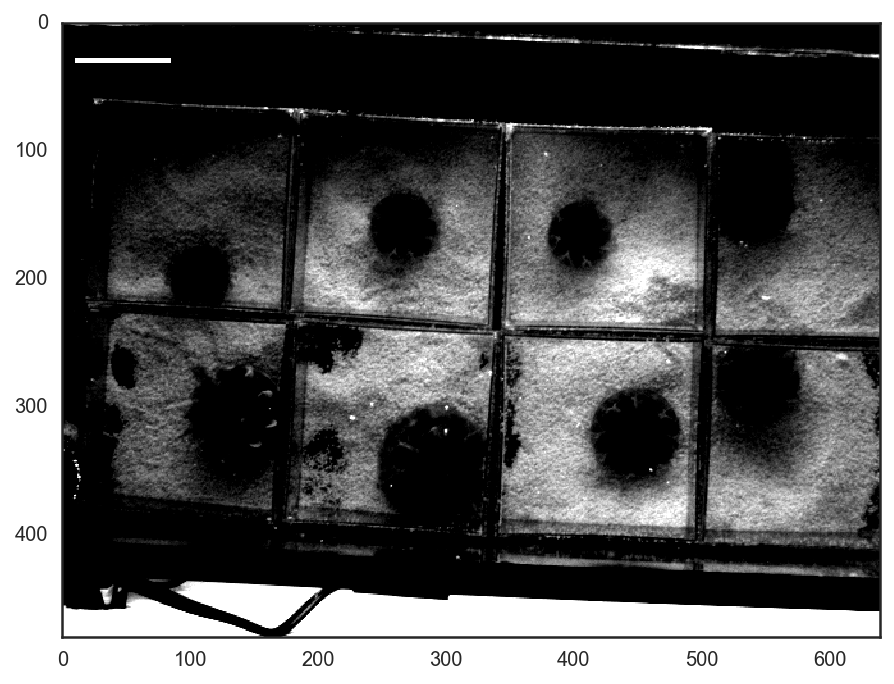

In [11]:
def burn_scale_bar(im, length, i_pos, j_pos, width=4, white=True):
    """
    Burn a horizontal scale bar starting at i_pos, j_pos.
    All units of inputs are interpixel distance.
    """
    im_out = im.copy()
    
    if white:
        pixel_val = skimage.dtype_limits(im)[1]
    else:
        pixel_val = skimage.dtype_limits(im)[0]
    
    im_out[i_pos-(width//2):i_pos+(width//2), j_pos:j_pos+length] = pixel_val
    return im_out
    
# Put black scale bar
im_sb = burn_scale_bar(im, 5 / interpixel_distance, 30, 10)

# Look at it
with sns.axes_style('white'):
    skimage.io.imshow(im_sb)

Note, though, that in the case of an image like this, we could just put something like, "Jelly fish boxes are 4$\times$4 inches," in our caption, and be done with it.  I'm showing you this because it is important to know how to do for many of the images you come across.

`scikit-image` currently does not have capability to add text.  You can make scale bars with text easily when preparing figures for publication within a Python framework using [OpenCV](http://opencv.org/) or by using [Fiji](http://fiji.sc/).

I want to make a final couple of notes on scale bars.  Some will argue that the scale bars could be added as vector graphics with nice, clean text.  There is no inherent problem with this, but in practice, images often get stretched and rearranged for display in presentations or in publications.  It is often difficult to control how various layers on objects will scale when this is done.  I prefer to keep myself out of trouble and burn in the scale bars.  Finally, make sure your scale bars are not burned in to the image you are actually analyzing, only those for viewing!  Remember, by burning in the scale bar in something you are analyzing, you are changing *data*!

## False coloring for image display

Remember, showing an image on screen or printing it on a piece of paper is *plotting data*.  We are free to choose *how* we plot it.  The common convention is to show the image in gray scale, but we need not do that.  We can instead look at the image in false color.  ("False" is a misnomer here, since any color is just a representation of photon counts on a detector.)  *This is not adding or subtracting information; it is merely changing the way we display it.*  Since images are typically sequential data, sequential colormaps are preferred.  In cases where we might have stark separation between dark and light, a diverging colormap is useful.  My favorite sequential and diverging colormaps for images are, respectively, `plt.cm.viridis` (Matplotlib's fantastic new default colormap) and `plt.cm.RdBu_r`.  Let's look at the image with these colormaps.

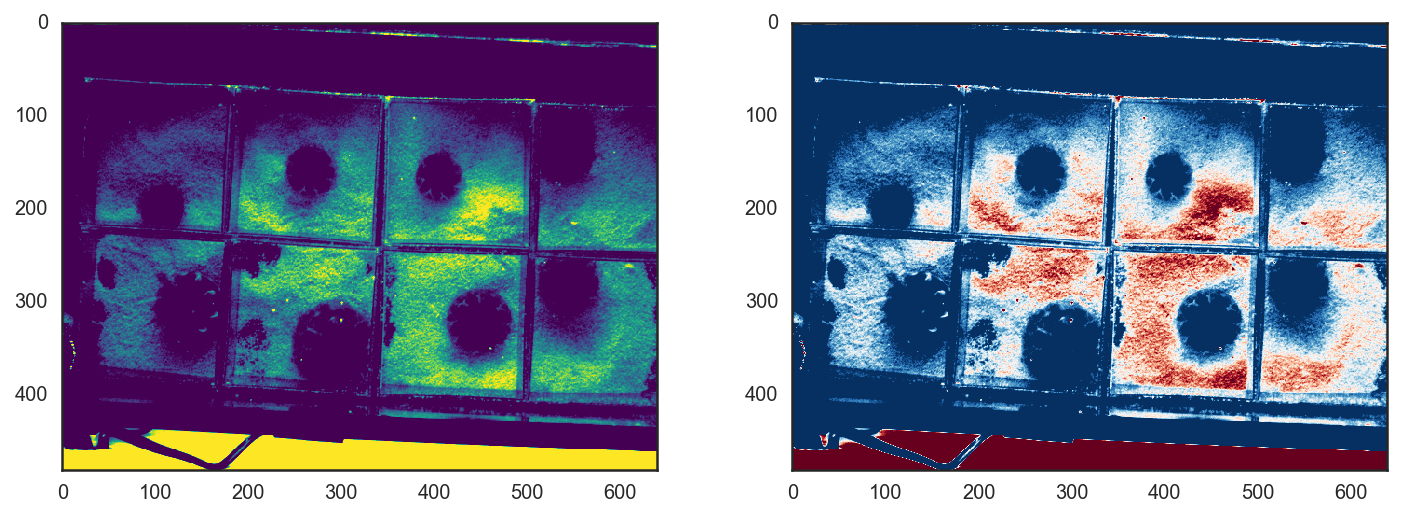

In [12]:
# Set up figure with subplots
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(im, cmap=plt.cm.viridis)
    ax[1].imshow(im, cmap=plt.cm.RdBu_r)

It is often easier to see fine detail with false coloring.  While not important for our analysis, we can, for example, see the nuances in brightness in the sand on which the jellyfish sit.

## Loading a stack of images
While we have done some nice things with single images, we really want to be able to sequentially look at all of the images of the movie, a.k.a. the stack of images.

`scikit-image` has a convenient way to do this using the `skimage.io.ImageCollection` class.  We simple give it a string matching the pattern of the file names we want to load.  In our case, this is `im_glob` that we have already defined.  An important kwarg is `conserve_memory`.  If there are many images, it is best to select this to be `True`.  For few images, selecting this to be `False` will result in better performance because all of the images will be read into RAM.  Let's load the daytime movie as an `ImageCollection`.  (Note: we're not actually loading them all in; we just creating an object that knows where the images are so we can access them at will.)

In [13]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)

Conveniently, the `ImageCollection` has nice properties.  Typing `len(ic)` tells how many images are in the collection.  `ic[157]` is the 157th image in the collection.  There is one problem, though.  All of the images are read in with all three channels.  We would like to only include one channel, since the others are redundant.  To do this, we can instantiate the `ImageCollection` with the `load_func` kwarg.  This specifies a function that reads in and returns a NumPy array with the image.  The default is `load_func=skimage.io.imread`, but we can write out own.  We'll write a function that loads the image and then just returns the red channel and reinstantiate the `ImageCollection` using that load function.

In [14]:
def squish_rgb(im):
    return skimage.io.imread(im)[0,:,:]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)

We should also have time stamps for the data in the images.  We know the frame rate is 15 frames per second, so we can attach times to each image.  Normally, these would be in the metadata of the images and we would fish that out, but for this example, we will just generate our own time points (in units of seconds).

In [15]:
fps = 15
t = np.arange(0, len(ic)) / fps

## Setting an ROI

A **region of interest**, or ROI, is part of an image or image stack that we would like to study, ignoring the rest.  Depending on the images we are analyzing, we may be able to automatically detect ROIs based on well-defined criteria.  Often, though, we need to manually pick regions in an image as our ROI.

`scikit-image` is an open source project that is constantly under development.  It currently does not have a way to specify ROIs, but it is on the list of functionality to be added.

So, I wrote my own ROI utility, which is included in [`bebi103_utils`](https://github.com/justinbois/bebi103_utils).  It takes a set of vertices that define a polygon, the inside of which constitutes a region of interest.  (Note that the polygon cannot have crossing lines.)  It returns a tuple that contains a **mask** for the ROI, a **bounding box**, and the mask for an image consisting entirely of the bounding box.  An ROI mask is the same shape as the image, except where the image has a pixel value, the ROI mask has a `True` value if the pixel is within the ROI and has a `False` value it if is outside.  The bounding box defines the smallest square subimage that completely contains the ROI.  Finally, it is convenient to have a mask that is reindexed such that (0,0) is the upper left corner of the bounding box.

To get the vertices, we can use the `plt.ginput()` function.  This cannot be demonstrated in an IPython notebook with inline `matplotlib`, so I do not show it here.  The syntax is below, with `ginput()` commented out, with its output instead hard coded.  In this example, I drew a square in the image to select a single box.

In [16]:
# Select the condos as ROIs.  Use plt.ginput to get vertices
# Uncomment the below to use ginput.  Hit enter when finished selecting verts
# verts = plt.ginput(100)

verts = [(348.79397748093913, 246.73039544685778),
         (491.30157835613034, 249.91294732744518),
         (487.05817584868049, 392.77416507825723),
         (347.37950997845581, 386.76267819270322)]

Now we can use `bebi103.verts_to_roi()` to make make the ROI.

In [17]:
roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic[0].shape)

Now that we have defined the ROI, let's look at it.  We will use a trick where we take a grayscale image, convert it to RGB, and then add more blue in certain regions to highlight.

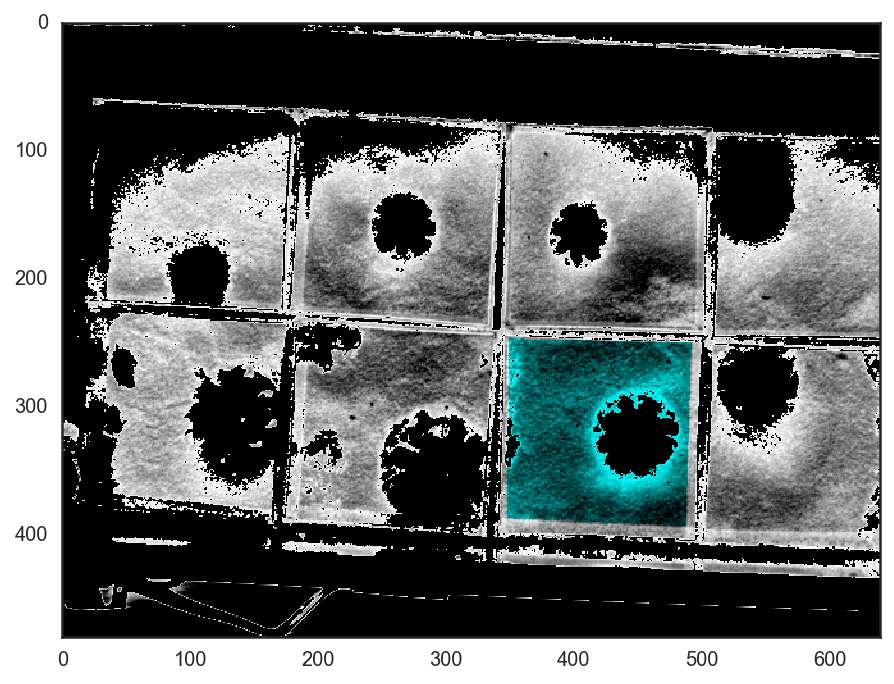

In [18]:
# Make grayscale image that is now RGB
im = np.dstack(3*[ic[0]])

# Max out blue channel
im[roi,0] = skimage.dtype_limits(ic[0])[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

If you just want to look at the region of the image that bounds the ROI, you can do the following.

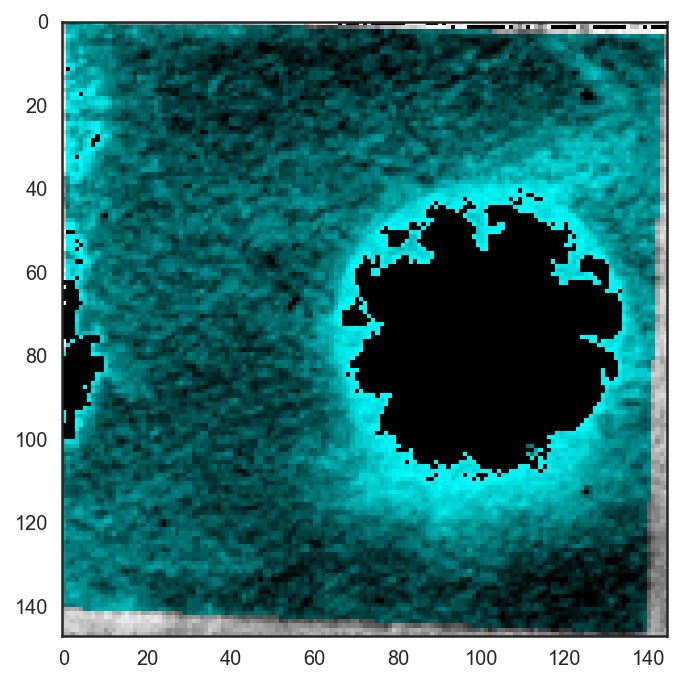

In [21]:
# Get cropped image and ROI within it
im = ic[0][roi_bbox]
im_cropped_roi = roi_box

# Make grayscale image that is now RGB
im = np.dstack(3*[im])

# Max out blue channel
im[im_cropped_roi,0] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

## Some simple analysis

We are interested in the rate at which the jellyfish pulse.  Since the jellyfish are dark on a black background, we could just watch how the total pixel intensity of our respective ROIs change over time to get the pulsing frequency.  This will not really tell use about the shape of the jellyfish or any fine detail, but it will hopefully be enough to get us a rough estimate of pulsing frequency.

Of course, in order to do this, we need to know the frame rate.  These videos were acquired at a frame rate of 15 frames per second (fps).  We should store this information in our `XYTStack`.

In [ ]:
# Store time data in XYTStack
jelly_xyt.t = np.arange(jelly_xyt.size_t) * 1.0 / 15.0

With this in hand, let's compute the total pixel intensity in region 2 through time.

In [ ]:
# Set up NumPy array to store total pixel intensity
total_int_2 = np.empty(jelly_xyt.size_t)

# Look through and compute total intensity in condo 2
for i in range(jelly_xyt.size_t):
    total_int_2[i] = (jelly_xyt.im(i, roi=2) * jelly_xyt.roi[2][2]).sum()

Great!  Let's plot the result!

In [ ]:
# Plot time course of total intensity
plt.plot(jelly_xyt.t, total_int_2 / total_int_2.max(), 'k-', lw=0.5)
plt.xlim((0.0, 50.0))

In [ ]:
skimage.io.imshow(jelly_xyt.im(jelly_xyt.size_t-1, roi=2))

The jellyfish does not move much during this image acquisition, so we can tighten our ROI.

In [ ]:
verts = [(388.94220430107521, 134.82258064516134),
         (389.44959677419354, 155.62567204301078),
         (398.07526881720423, 172.87701612903228),
         (413.80443548387092, 183.53225806451616),
         (435.62231182795693, 180.48790322580649),
         (449.82930107526875, 165.77352150537638),
         (453.38104838709671, 145.98521505376348),
         (445.77016129032256, 132.79301075268822)]
jelly_xyt.roi.append(jb.verts_to_roi(verts, 
                                     jelly_xyt.size_x, jelly_xyt.size_y))

# Look at ROI
im = jelly_xyt.im(200, roi=3)
im = np.dstack(3 * [im])

# Make ROI blue, but use ROI based on bounding box
im[jelly_xyt.roi[3][2], 2] = jelly_xyt.max_pixel

# Look at the image
skimage.io.imshow(im)

We'll use this zoomed-in image/ROI to compute total intensities.

In [ ]:
# Set up NumPy array to store total pixel intensity
total_int_3 = np.empty(jelly_xyt.size_t)

# Look through and compute total intensity in condo 2
for i in range(jelly_xyt.size_t):
    total_int_3[i] = (jelly_xyt.im(i, roi=3) * jelly_xyt.roi[3][2]).sum()

Now, we'll do a background substraction to make peak identification easier.

In [ ]:
# Do a strong Gaussian blur to get background
bg = jb.nw_kernel_smooth(jelly_xyt.t, jelly_xyt.t, total_int_3, 
                         jb.gauss_kernel, lam=100)

# Make background subtracted signal
total_int_minus_bg = total_int_3 - bg

Next, we'll smooth the signal with an Epanechnikov kernel with a half second time window.

In [ ]:
# Sampling for smoothed data (same as original)
t_smooth = np.linspace(jelly_xyt.t.min(), jelly_xyt.t.max(), 
                       jelly_xyt.size_t)

# Smooth data with Epanechnikov filter with 0.5 second window
trace_smooth = jb.nw_kernel_smooth(t_smooth, jelly_xyt.t, 
                                   total_int_minus_bg,
                                   jb.epan_kernel, lam=0.5)

To find the peaks and valleys, we use the convenient functions `scipy.signal.argrelmax` and `scipy.signal.argrelmin`.  We then identify bonafide peaks as those above background with minima on either side that are below background.

In [ ]:
# Find maxes and mins
max_inds = scipy.signal.argrelmax(trace_smooth)[0]
min_inds = scipy.signal.argrelmin(trace_smooth)[0]

# Number of maxima and minima
n_max = len(max_inds)
n_min = len(min_inds)

# Find out if min is first
min_first = max_inds[0] > min_inds[0]

# Only keep max if it is above zero and min to left and right below 0
if min_first:
    good_max_inds = (trace_smooth[max_inds[:-1]] > 0.0) \
                    & (trace_smooth[min_inds[:n_max-1]] < 0.0)\
                    & (trace_smooth[min_inds[1:n_max]] < 0.0)
    max_inds = max_inds[:-1][good_max_inds]
else:
    good_max_inds = (trace_smooth[max_inds[1:-1]] > 0.0) \
                    & (trace_smooth[min_inds[:n_max-2]] < 0.0) \
                    & (trace_smooth[min_inds[1:n_max-1]] < 0.0)
    max_inds = max_inds[1:-1][good_max_inds]

Finally, we can plot the traces to see how well we did.

In [ ]:
# Plot smooth trace
plt.plot(jelly_xyt.t, total_int_minus_bg, 'k-', lw=0.5)
plt.plot(t_smooth, trace_smooth, 'r-', lw=0.5)
plt.plot(t_smooth[max_inds], trace_smooth[max_inds], 'b*')
plt.xlim((0, 50))
plt.xlabel('time (s)')
plt.ylabel('bg subtr. tot. ROI pixel int.')

We can now compute the distances between peaks as a function of time.

In [ ]:
# Compute distance between maxima
peak_dists = np.diff(t_smooth[max_inds])

To get a investigate the interpeak distances, we'll generate several plots.  First, we'll compute the interpeak distance over time

In [ ]:
# Plot peak distances over time
plt.plot(t_smooth[max_inds[1:]], peak_dists, 'k.')
plt.margins(x=0.02)
plt.xlabel('time (s)')
plt.ylabel('time betw. contractions (s)')

We see that there is a stready pulsing period of two seconds, but that there are occasional pauses in pulsing.  We can plot a histogram of the time between contractions as a histogram.

In [ ]:
# Plot histogram
n, b, p = plt.hist(peak_dists, bins=np.sqrt(len(max_inds[1:])), normed=False)
plt.xlabel('time betw. contractions (s)')
plt.ylabel('count')

We can also look at these data as a jitter plot.

In [ ]:
# Column positions
x_pos = 0.0

# Jitter by adding normally distributed random number and plot with 
# alpha < 1, which gives transparency
np.random.seed(42)
x = np.random.normal(x_pos, 0.04, size=len(peak_dists))
plt.plot(x, peak_dists, 'ko', alpha=0.3)
plt.xticks([])
plt.ylabel('time betw. contractions (s)')

Note that this small data sets precludes us from getting good statistics on the pause times (long time between peaks in integrated pixel intensity).  This makes for an interesting next study.

## Your turn

Can you do the same analysis with the night time data set and compare the results to the day?